In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from Bio import SeqIO
from matplotlib.ticker import MultipleLocator

In [2]:
# setting color palete for figures
sns.set_palette('muted')

In [3]:
# reading in names of removed sequences so they will not be considered here
%store -r removed_n

# Making mutation count df

In [4]:
# function that makes a dictionary containing all found location in a sequence position
def compare_seq(reference, sequence, dictionary):
    for i in range(len(reference)):
        if sequence[i] == 'n':
            pass
        elif reference[i] != sequence[i]:
            if i not in dictionary.keys():
                dictionary[i] = [f'{reference[i]} -> {sequence[i]}']
            else: 
                dictionary[i] = dictionary[i] + [f'{reference[i]} -> {sequence[i]}']

In [5]:
# parse MSA file so each sequence is a seperate entry in a dictionary
seq_dict = SeqIO.to_dict(SeqIO.parse('./msa.fasta', 'fasta'))
total = 0 

# apply function to every sequence in dictionary that is not the reference sequence
mutation_dict = {}
for key in seq_dict:
    if key == 'reference':
        reference = seq_dict[key]
    elif key not in removed_n:
        total += 1
        seq = seq_dict[key]
        compare_seq(reference, seq, mutation_dict)

In [6]:
# make a dictionary for each position and their mutations
data = {}
data['position'] = []
data['change'] = []
data['type'] = []
data['occurrences'] = []

# for each position see if the sequence is different from the reference sequence
for position in range(len(reference)):
    if position in mutation_dict:
        changes = set(mutation_dict[position])
        for change in changes:
            occurrences = mutation_dict[position].count(change)
            if change.startswith('-'):
                m_type = 'insertion' # mutation type is noted as insertion
            elif change.endswith('-'):
                m_type = 'deletion' # mutation type is noted as insertion
            else:
                m_type = 'mutation' # mutation type is noted as mutation
            # if there is a change, an entry is made in the data dictionary containing, the position
            # change, type and the number of occurrences
            data['position'].append(position)
            data['change'].append(change)
            data['type'].append(m_type)
            data['occurrences'].append(occurrences)

# convert this dictionary into a df
df = pd.DataFrame.from_dict(data)

In [7]:
# show the entire dataframe
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df)

     position  change      type  occurrences
0           0  g -> -  deletion         2692
1           1  c -> -  deletion         2656
2           2  t -> -  deletion         2620
3           3  g -> -  deletion         2603
4           4  c -> -  deletion         2579
5           5  a -> -  deletion         2552
6           6  t -> -  deletion         2509
7           7  g -> -  deletion         2448
8           8  g -> -  deletion         2383
9           9  c -> -  deletion         2333
10         10  g -> -  deletion         2301
11         11  c -> -  deletion         2254
12         12  c -> -  deletion         2207
13         13  g -> -  deletion         2179
14         14  c -> -  deletion         2143
15         15  c -> -  deletion         2095
16         16  t -> -  deletion         2039
17         17  t -> -  deletion         1997
18         18  c -> -  deletion         1941
19         19  a -> -  deletion         1883
20         20  g -> -  deletion         1838
21        

In [8]:
del_df = df[df['type'] == 'deletion'].copy(deep = True).set_index('position').reindex(range(3244+1))

mut_df = df[df['type'] == 'mutation'].copy(deep = True).drop(['change', 'type'], axis = 1).set_index('position').groupby('position').sum().reindex(range(3244+1))

# Plots


## Plotting entire flanked locus

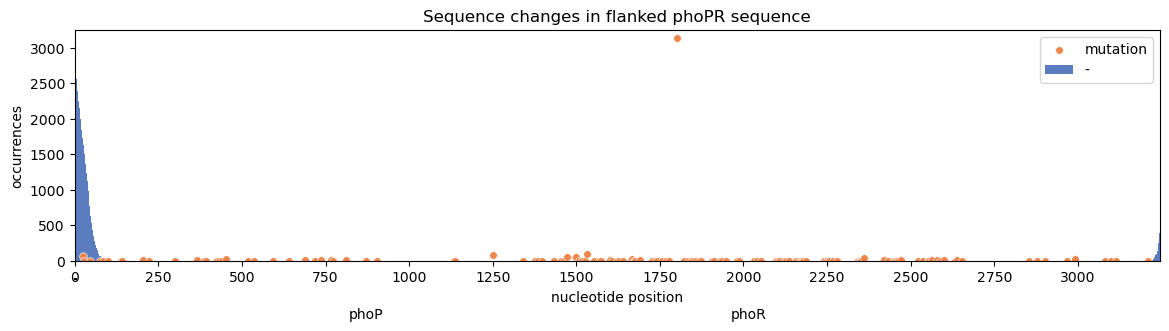

In [9]:
fig, ax = plt.subplots(figsize=(14, 3))

sns.barplot(x = del_df.index, y = del_df['occurrences'], ax = ax, label = '-')
sns.scatterplot(x = mut_df.index, y = mut_df['occurrences'], ax = ax, s = 30, label = 'mutation')
    
ax.xaxis.set_major_locator(MultipleLocator(250))

ax.set_title('Sequence changes in flanked phoPR sequence')
ax.set_xlabel('nucleotide position')
ax.set_ylim(0, 3250)
ax.set_xlim(0, len(del_df))

# setting labels below x-axis for sequence regions
trans = ax.get_xaxis_transform()
ax.plot([-.4,2.4],[-.08,-.08], color="k", transform=trans, clip_on=False)
ax.annotate('phoP', xy=(871, -.2), xycoords=trans, ha="center", va="top")
ax.annotate('phoR', xy=(2016, -.2), xycoords=trans, ha="center", va="top")

ax.legend(loc='upper right')

plt.show()

## (not using) Only PhoP

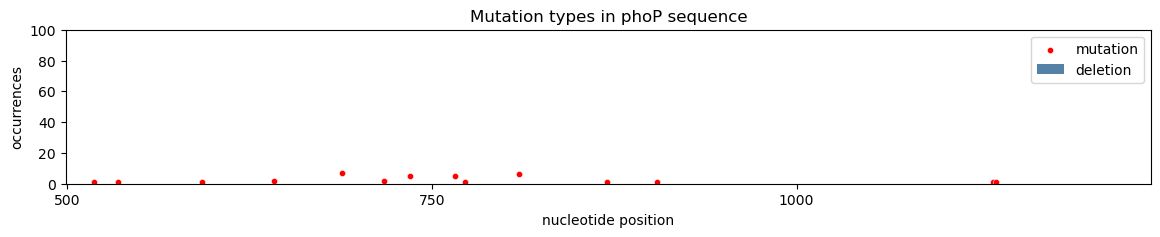

In [10]:
fig, ax = plt.subplots(figsize=(14, 2))

sns.barplot(x = del_df.index, y = del_df['occurrences'], color = 'steelblue', ax = ax, label = 'deletion')
sns.scatterplot(x = mut_df.index, y = mut_df['occurrences'], color = 'red', ax = ax, s = 20, label = 'mutation')

#ax.xaxis.get_major_locator()                    
#ax.xaxis.get_major_formatter()    
ax.xaxis.set_major_locator(MultipleLocator(250))

ax.set_title('Mutation types in phoP sequence')
ax.set_xlabel('nucleotide position')
ax.set_xlim(499, 499+744) #1243
ax.set_ylim(0, 100)
plt.legend()

ax.legend(loc='upper right')
plt.show()

## (not using) Only PhoR

In [11]:
outlier_index = mut_df['occurrences'].sort_values(ascending=False).index[0]
outlier_value = mut_df.loc[outlier_index]
mut_no_outlier_df = mut_df.copy(deep = True)
mut_no_outlier_df.loc[outlier_index] = None

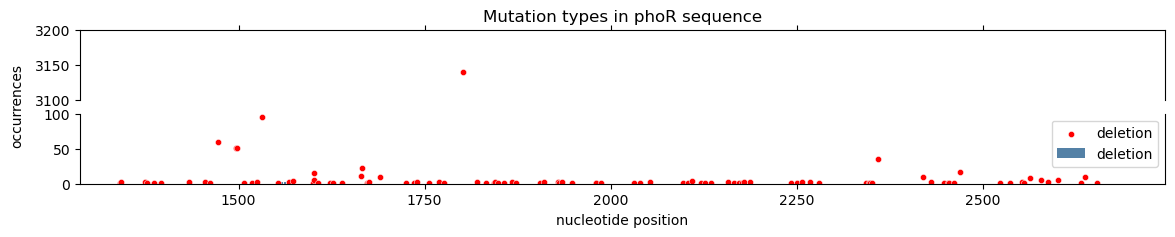

In [12]:
# from https://stackoverflow.com/questions/76894997/barplot-with-continuous-bars-but-broken-y-axis
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, figsize=(14, 2))

sns.barplot(x = del_df.index, y = del_df['occurrences'], color = 'steelblue', ax = ax2, label = 'deletion')

sns.scatterplot(x = outlier_index, y = outlier_value, ax = ax1, color = 'red', s = 20)
sns.scatterplot(x = mut_no_outlier_df.index, y = mut_no_outlier_df['occurrences'], color = 'red', ax = ax2, s = 20, label = 'deletion')
ax1.xaxis.tick_top()
#ax.xaxis.get_major_locator()                    
#ax.xaxis.get_major_formatter()    
ax1.xaxis.set_major_locator(MultipleLocator(250))

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax1.set_title('Mutation types in phoR sequence')
ax2.set_xlabel('nucleotide position')

ax1.set_ylabel('')
ax2.set_ylabel('')
ax1.set_xlim(1287, 1287 +1458)
ax2.set_xlim(1287, 1287 +1458) #2745

ax1.set_ylim(3100, 3200)
ax2.set_ylim(0, 100)

fig.text(0.075, 0.5, 'occurrences', va='center', rotation='vertical')

ax2.legend(loc = 'upper right')

plt.show()

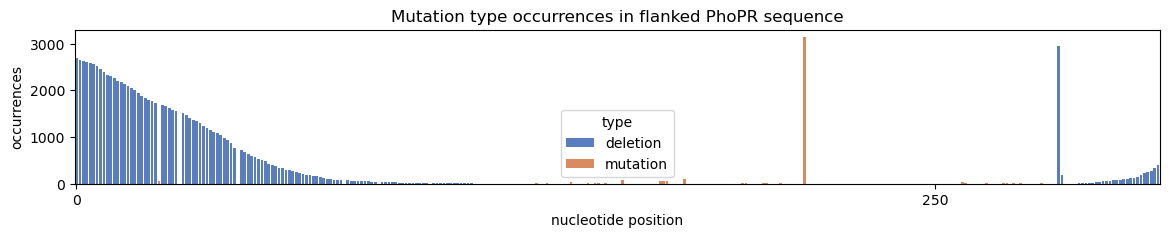

In [13]:
###### DEFUNCT ######


fig, ax = plt.subplots(figsize=(14, 2))
ax = sns.barplot(x = df.index, y = df['occurrences'], hue = df['type'], ax = ax)

ax.xaxis.get_major_locator()                    
ax.xaxis.get_major_formatter()    
ax.xaxis.set_major_locator(MultipleLocator(250))

ax.set_title('Mutation type occurrences in flanked PhoPR sequence')
ax.set_xlabel('nucleotide position')
plt.show()

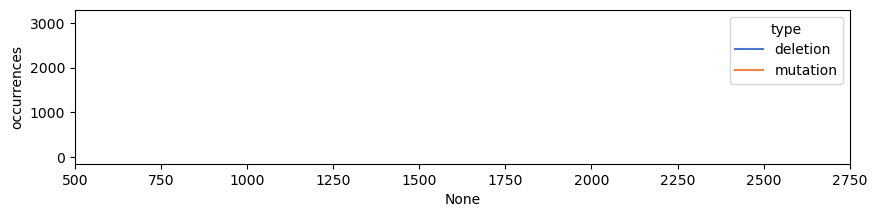

In [14]:
###### DEFUNCT ######
fig, ax = plt.subplots(figsize=(10, 2))
ax = sns.lineplot(x = df.index, y = df['occurrences'], hue = df['type'], ax = ax)

ax.xaxis.get_major_locator()                    
ax.xaxis.get_major_formatter()    
ax.xaxis.set_major_locator(MultipleLocator(250))
ax.set_xlim(500, 2750)
plt.show()